Imports ~

In [4]:
# File imports
import signin_config
from book_functions import *

# Reloads above files as they are saved internally
%reload_ext autoreload
%autoreload 2

# Base imports
import pandas as pd
import numpy as np
import json
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# NLP imports
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from scipy import stats
import nltk
from nltk.corpus import gutenberg, stopwords
from nltk.collocations import *
from nltk import FreqDist
from nltk import word_tokenize
import string
import re
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *

# !pip install rake-nltk
from rake_nltk import Rake


# scraping imports
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.common.exceptions import TimeoutException
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

In [5]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Experimental Process


## Clean data 

- look for nan values, empty descriptions, clean types (str -> int), (organize pictures)
    ratings, number of ratings, pages (str -> int)


Merging with other dataframe -->

In [31]:
# df = pd.read_csv('goodread_data2_reb1.csv')
# df1 = df1 = pd.read_csv('cleaned_gr_data_quan2.csv')
# df_genres = pd.concat([df,df1], sort=True)
# df_parent = pd.concat([df,df1], sort=True)

In [32]:
# df_genres.drop(['Unnamed: 0','format'], axis=1, inplace=True) # drop format and random first column
# df_genres.pages = df_genres.pages.apply(lambda x: float(str(x).split(' ')[0]))
# df_genres.genre = df_genres.genre.apply(lambda x: x.replace('{','').replace('}',''))
# df_genres.genre = df_genres.genre.apply(lambda x: x.replace("'",''))
# df_genres['genre'] = df_genres['genre'].map(lambda x: x.lower().split(','))

In [135]:
df = pd.read_csv('goodread_img1.csv')
df.drop(['Unnamed: 0'], axis=1,inplace=True)#,'pages','format'], axis=1,inplace=True)

In [41]:
df.genre = df.genre.apply(lambda x: x.replace('{','').replace('}',''))
df.genre = df.genre.apply(lambda x: x.replace("'",''))
df['genre'] = df['genre'].map(lambda x: x.lower().split(','))

## NLP cleaning

Filtering, Stemming, Lemming and TF-IDF to produce an nlp-friendly dataset named 'nlp'

Functions to clean:

In [42]:
# new stopwords_list and regex pattern

pattern = "([a-zA-Z]+(?:'[a-z]+)?)"
stopwords_list = stopwords.words('english')
stopwords_list += list(string.punctuation)
stopwords_list += ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
stopwords_list += ['book', 'author', 'novel', 'year', 'come', 'stories','story','thing','alex', 'stephanie', 
                   'bestseller']

In [43]:
nlp = pd.DataFrame(df.description)
nlp['describe_raw'] = nlp.description.apply(lambda info: nltk.regexp_tokenize(info, pattern));
nlp['raw_token'] = nlp.describe_raw.apply(lambda x: [word.lower() for word in x]);
nlp['token_list'] = nlp.raw_token.apply(lambda x : [word for word in x if word not in stopwords_list]);
nlp['freq_dist'] = nlp.describe_raw.apply(lambda x: FreqDist(x));
nlp['freq_dist_top'] = nlp.freq_dist.apply(lambda x: x.most_common(20));

# apply tfidf to vectorize
tf = TfidfVectorizer(analyzer='word', ngram_range=(1, 3), min_df=0, stop_words='english')
nlp['tfidf'] = tf.fit_transform(nlp['description'])

## Get Keywords

In [6]:
dff = pd.read_csv('goodreads_updated.csv')
dff.drop('Unnamed: 0', axis=1,inplace=True)
stop_point = 7000
dff = dff.iloc[:stop_point]

If starting the notebook for the first time, run the following. Otherwise continue on

In [5]:
# create author and genre column clean
dff['au_ge'] = dff.authors.apply(lambda x: x.lower().replace(' ','')) + ' ' + dff.genre.apply(lambda x: x.replace(' ','').replace(',',' ') if x!='set()' and type(x)!=float else ' ')
dff['au_ge'] = dff.au_ge.apply(lambda x: x.lower() if type(x) != float else x) 


# clean description for keyword search

dff['desc_clean'] = dff.description
for c in string.punctuation + '”' + '“':
    if c == '`' or c == "'":
        dff.desc_clean = dff.desc_clean.apply(lambda x: x.replace(c,"") if type(x)!=float else x)
    else:
        dff.desc_clean = dff.desc_clean.apply(lambda x: x.replace(c," ") if type(x)!=float else x)
for s in string.digits:
    dff.desc_clean = dff.desc_clean.apply(lambda x: x.replace(s,"") if type(x)!=float else x)
    dff.desc_clean = dff.desc_clean.apply(lambda x: x.replace('”','') if type(x)!=float else x)
    dff.desc_clean = dff.desc_clean.apply(lambda x: x.replace('“','') if type(x)!=float else x)


dff['key_words'] = ""
for idx, row in dff.iterrows():
    plot = row['desc_clean']
    if type(plot) == float:
        continue
    
    # instantiating Rake, by default is uses english stopwords from NLTK
    # and discard all puntuation characters
    r = Rake()
    # extracting the words by passing the text
    r.extract_keywords_from_text(plot)
    # getting the dictionary with key words and their scores
    key_words_dict_scores = r.get_word_degrees()

    # assigning the key words to the new column
    keys = list(key_words_dict_scores.keys())
    keys = ' '.join(keys)
    dff.loc[idx, 'key_words'] = keys

# combine these all into one bag of words
dff['bag_of_words'] = dff.au_ge.apply(lambda x: x if type(x)!=float else '') + ' ' + dff.key_words.apply(lambda x: x if type(x)!=float else '')

In [29]:
dff.sample(3)

,titles,authors,ratings,num_ratings,id,img,description,pages,genre,format,isbn,au_ge,desc_clean,key_words,bag_of_words
2381,The Waste Land and Other Writings,T.S. Eliot,4.21,3338,34082,https://i.gr-assets.com/images/S/compressed.ph...,"Also includes Prufrock and Other Observations,...",272.000,"Poetry, Classics, Fiction",paperback,9780375759345,t.s.eliot poetry classics fiction,Also includes Prufrock and Other Observations ...,seemed potent new poetic language words psycho...,t.s.eliot poetry classics fiction seemed poten...
3751,Pather Panchali: Song of the Road,Bibhutibhushan Bandyopadhyay,4.55,3735,617097,https://i.gr-assets.com/images/S/compressed.ph...,Pather Panchali deals with the life of the Roy...,316.000,"Fiction, Classics, Cultural, India, Novels",paperback,9780253201867,bibhutibhushanbandyopadhyay fiction classics c...,Pather Panchali deals with the life of the Roy...,anguish name book first appeared roy family co...,bibhutibhushanbandyopadhyay fiction classics c...
5224,Castellio contra Calvino: Conciencia contra vi...,John Steinbeck,4.37,778,65054,https://i.gr-assets.com/images/S/compressed.ph...,"""Tolerancia frente a intolerancia, libertad fr...",256.000,"History, Nonfiction, Religion, Literature",paperback,9788495359568,johnsteinbeck history nonfiction religion lite...,Tolerancia frente a intolerancia libertad fren...,tutela humanismo frente tolerancia la comunida...,johnsteinbeck history nonfiction religion lite...


To save or load json files, run the following:

In [54]:
dff.to_json(r'goodreads_updated.json', orient='index')

# with open('goodreads_updated.json') as f:
data = pd.read_json('goodreads_updated.json', orient='index').reset_index(drop=True)

# Testing Functions

## Tesing Recommendation System

Create cosine similarity matrix using linear_kernal on tfidf vectorized bag of words

In [81]:

tf = TfidfVectorizer(analyzer='word', ngram_range=(1, 3), min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(data_df['bag_of_words'])

cosine_similarities = linear_kernel(tfidf_matrix, tfidf_matrix)


## Testing Processing Functions

In [19]:
dff = pd.read_csv('goodreads_updated.csv')
dff.drop("Unnamed: 0", axis=1, inplace=True)

In [26]:
aug, kee = process_and_almost_bag(dff['authors'], dff['genre'], dff['desc_clean'])
boow = make_bow(aug, kee)

Stop here - clean below before final push

# EDA and Further Exploration

Import this dataframe to retain consistency for EDA

In [50]:
df_eda = pd.read_csv('goodreads_updated.csv')
df_eda.drop("Unnamed: 0", axis=1, inplace=True)
# clean relevant columns if necessary
df_eda.ratings = df_eda.ratings.apply(lambda x: float(x) if '.' in x else np.nan)
df_eda.num_ratings = df_eda.num_ratings.apply(lambda x: float(x) if x !='rating' else np.nan )
df_eda.isbn = df_eda.isbn.apply(lambda x: float(x) if type(x) != float and 'ISBN' not in x else float(x.split()[-1]) if type(x)==str else np.nan)

In [72]:
df_eda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7000 entries, 0 to 6999
Data columns (total 15 columns):
titles          7000 non-null object
authors         7000 non-null object
ratings         6982 non-null float64
num_ratings     6985 non-null float64
id              7000 non-null int64
img             6803 non-null object
description     6720 non-null object
pages           6480 non-null float64
genre           6854 non-null object
format          6079 non-null object
isbn            5826 non-null float64
au_ge           7000 non-null object
desc_clean      6720 non-null object
key_words       6720 non-null object
bag_of_words    7000 non-null object
dtypes: float64(4), int64(1), object(10)
memory usage: 820.4+ KB


## EDA of continuous data

pages, ratings, num_ratings, isbn, id

In [58]:
print('pages:\n',df_eda.pages.describe(), '\nratings:\n',df_eda.ratings.describe(), '\nnum_ratings:\n',  df_eda.num_ratings.describe(), )

pages:
 count    6480.000
mean      289.179
std       610.903
min         0.000
25%       158.000
50%       239.000
75%       336.000
max     32000.000
Name: pages, dtype: float64 
ratings:
 count   6982.000
mean       3.896
std        0.312
min        0.000
25%        3.710
50%        3.910
75%        4.110
max        4.820
Name: ratings, dtype: float64 
num_ratings:
 count      6985.000
mean       6526.740
std       72605.949
min           0.000
25%         154.000
50%         400.000
75%        1407.000
max     3411877.000
Name: num_ratings, dtype: float64


Pages:

In [60]:
print('pages:\n',df_eda.pages.describe())

pages:
 count    6480.000
mean      289.179
std       610.903
min         0.000
25%       158.000
50%       239.000
75%       336.000
max     32000.000
Name: pages, dtype: float64


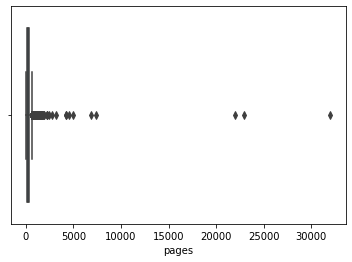

In [59]:
sns.boxplot(df_eda.pages);

Ratings:

In [68]:
print('ratings:\n',df_eda.ratings.describe(),)

ratings:
 count   6982.000
mean       3.896
std        0.312
min        0.000
25%        3.710
50%        3.910
75%        4.110
max        4.820
Name: ratings, dtype: float64


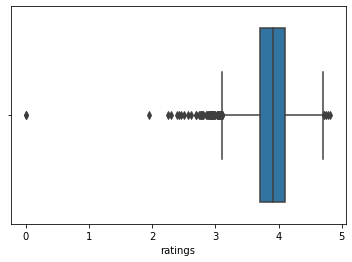

In [66]:
sns.boxplot(df_eda.ratings);

Num_ratings:

In [67]:
print('num_ratings:\n',  df_eda.num_ratings.describe())

num_ratings:
 count      6985.000
mean       6526.740
std       72605.949
min           0.000
25%         154.000
50%         400.000
75%        1407.000
max     3411877.000
Name: num_ratings, dtype: float64


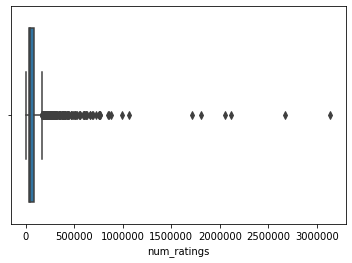

In [98]:
sns.boxplot(df_eda.num_ratings);

In [74]:
len(df_eda[(df_eda.num_ratings > 80000)]) #& (df.num_ratings > 27000)])

79

# Future considerations:

## NLP Topic Modeling

Preprocessing data:

In [130]:
processed_docs = df['description'].map(preprocess)

In [131]:
dictionary = gensim.corpora.Dictionary(processed_docs)

In [132]:
dictionary.filter_extremes(no_below=20, no_above=0.66, keep_n=10000)

Bag of Words on dataset

In [133]:
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

In [134]:
bow_doc_2001 = bow_corpus[2001]

In [135]:
from gensim import corpora, models
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]

In [140]:
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=10, id2word=dictionary, passes=4, workers=2)

In [141]:
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.021*"love" + 0.012*"life" + 0.010*"famili" + 0.010*"world" + 0.009*"girl" + 0.009*"know" + 0.008*"night" + 0.008*"secret" + 0.007*"power" + 0.007*"live"
Topic: 1 
Words: 0.011*"time" + 0.010*"life" + 0.009*"girl" + 0.009*"want" + 0.007*"world" + 0.007*"like" + 0.007*"know" + 0.007*"think" + 0.007*"secret" + 0.007*"peopl"
Topic: 2 
Words: 0.013*"famili" + 0.013*"life" + 0.011*"live" + 0.010*"love" + 0.009*"world" + 0.007*"time" + 0.006*"year" + 0.006*"work" + 0.005*"write" + 0.005*"woman"
Topic: 3 
Words: 0.015*"world" + 0.013*"love" + 0.010*"vampir" + 0.009*"live" + 0.009*"power" + 0.008*"magic" + 0.008*"secret" + 0.008*"life" + 0.007*"human" + 0.006*"danger"
Topic: 4 
Words: 0.013*"know" + 0.011*"dead" + 0.011*"world" + 0.008*"want" + 0.008*"like" + 0.007*"time" + 0.007*"life" + 0.006*"bestsel" + 0.006*"power" + 0.006*"rise"
Topic: 5 
Words: 0.013*"world" + 0.007*"live" + 0.006*"life" + 0.006*"famili" + 0.006*"lose" + 0.005*"take" + 0.005*"dead" + 0.005*"bestsel" + 

In [142]:
lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=10, id2word=dictionary, passes=2, workers=4)
for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

Topic: 0 Word: 0.003*"love" + 0.003*"life" + 0.003*"time" + 0.003*"kate" + 0.003*"live" + 0.002*"famili" + 0.002*"know" + 0.002*"want" + 0.002*"world" + 0.002*"woman"
Topic: 1 Word: 0.003*"girl" + 0.003*"love" + 0.003*"world" + 0.003*"famili" + 0.003*"secret" + 0.003*"time" + 0.002*"know" + 0.002*"life" + 0.002*"father" + 0.002*"live"
Topic: 2 Word: 0.003*"world" + 0.003*"life" + 0.002*"live" + 0.002*"love" + 0.002*"know" + 0.002*"famili" + 0.002*"time" + 0.002*"like" + 0.002*"think" + 0.002*"power"
Topic: 3 Word: 0.003*"love" + 0.003*"life" + 0.003*"want" + 0.003*"know" + 0.003*"friend" + 0.003*"world" + 0.002*"famili" + 0.002*"secret" + 0.002*"time" + 0.002*"live"
Topic: 4 Word: 0.003*"life" + 0.003*"love" + 0.003*"know" + 0.003*"famili" + 0.003*"friend" + 0.002*"time" + 0.002*"leav" + 0.002*"girl" + 0.002*"come" + 0.002*"world"
Topic: 5 Word: 0.004*"love" + 0.003*"vampir" + 0.003*"life" + 0.003*"famili" + 0.002*"world" + 0.002*"live" + 0.002*"know" + 0.002*"power" + 0.002*"peopl" + 

In [148]:
processed_docs[7090447]

['mother',
 'death',
 'year',
 'carter',
 'kane',
 'live',
 'suitcas',
 'travel',
 'globe',
 'father',
 'brilliant',
 'egyptologist',
 'julius',
 'kane',
 'carter',
 'homeschool',
 'younger',
 'sister',
 'sadi',
 'live',
 'grandpar',
 'london',
 'sadi',
 'carter',
 'want',
 'school',
 'friend',
 'chanc',
 'normal',
 'life',
 'carter',
 'sadi',
 'long',
 'time',
 'father',
 'year',
 'live',
 'apart',
 'sibl',
 'common',
 'christma',
 'sadi',
 'carter',
 'reunit',
 'father',
 'bring',
 'british',
 'museum',
 'promis',
 'go',
 'thing',
 'right',
 'accord',
 'plan',
 'carter',
 'sadi',
 'watch',
 'julius',
 'summon',
 'mysteri',
 'figur',
 'quick',
 'banish',
 'father',
 'caus',
 'fieri',
 'explos',
 'soon',
 'carter',
 'sadi',
 'discov',
 'god',
 'ancient',
 'egypt',
 'wake',
 'worst',
 'frighten',
 'scheme',
 'save',
 'father',
 'embark',
 'danger',
 'journey',
 'quest',
 'bring',
 'closer',
 'truth',
 'famili',
 'link',
 'hous',
 'life',
 'secret',
 'order',
 'exist',
 'time',
 'pharaoh

In [ ]:
for index, score in sorted(lda_model[bow_corpus[4310]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model.print_topic(index, 10)))

In [ ]:
for index, score in sorted(lda_model_tfidf[bow_corpus[4310]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model_tfidf.print_topic(index, 10)))

then on unseen document

## Topic Clustering

Pearson Correlation from https://github.com/nikitaa30/Content-based-Recommender-System/blob/master/recommender_system.py